In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error
from xgboost import cv, XGBRegressor
import seaborn as sns

In [2]:
path = "../data/brca/tcga/processed/GSE176078/ct_minor/prop_estimate_scores_primary_tumor_unstranded_subset_CID3586.csv"
scores = pd.read_csv(path,sep=',')
scores.head()

,ID,B cells Memory,B cells Naive,T cells CD8+,T cells CD4+,NK cells,NKT cells,Monocyte,Stromal_score,Immune_score,ESTIMATE_score
1,3C-AAAU,-5.431209,0.0000,0.0,0.0,-4.910174,-0.132676,-2.184786,-711.41,-906.98,-1618.39
2,3C-AALI,-7.368048,-5.5144,0.0,0.0,0.000000,-0.243500,-1.553714,122.66,511.24,633.91
3,3C-AALJ,0.000000,0.0000,0.0,0.0,-5.933138,-0.196054,-1.740791,400.91,539.25,940.16
4,3C-AALK,-3.926095,0.0000,0.0,0.0,-3.966422,-0.190500,-2.004020,799.11,-3.53,795.58
5,4H-AAAK,-5.534338,0.0000,0.0,0.0,0.000000,-0.170725,-1.877333,1075.36,-46.96,1028.40


In [3]:
scores.dtypes

ID                 object
B cells Memory    float64
B cells Naive     float64
T cells CD8+      float64
T cells CD4+      float64
NK cells          float64
NKT cells         float64
Monocyte          float64
Stromal_score     float64
Immune_score      float64
ESTIMATE_score    float64
dtype: object

In [4]:
scores.columns.tolist()

['ID',
 'B cells Memory',
 'B cells Naive',
 'T cells CD8+',
 'T cells CD4+',
 'NK cells',
 'NKT cells',
 'Monocyte',
 'Stromal_score',
 'Immune_score',
 'ESTIMATE_score']

In [5]:
cols = [
 'B cells Memory',
 'B cells Naive',
 'T cells CD8+',
 'T cells CD4+',
 'NK cells',
 'NKT cells',
 'Monocyte',
]
data = scores[cols]
labels = scores["Immune_score"]

In [6]:
labels.describe()

count    1075.000000
mean      214.757647
std       839.801561
min     -1724.480000
25%      -383.095000
50%        83.580000
75%       686.255000
max      3459.350000
Name: Immune_score, dtype: float64

In [7]:
# calculate the correlation matrix
corr = data.corr()
corr

,B cells Memory,B cells Naive,T cells CD8+,T cells CD4+,NK cells,NKT cells,Monocyte
B cells Memory,1.000000,0.075794,-0.070740,0.026357,-0.259865,0.048720,-0.185551
B cells Naive,0.075794,1.000000,-0.018762,0.156088,-0.116068,0.007271,0.007901
T cells CD8+,-0.070740,-0.018762,1.000000,-0.008729,0.117128,-0.044316,0.029196
T cells CD4+,0.026357,0.156088,-0.008729,1.000000,-0.006316,0.035257,0.079332
NK cells,-0.259865,-0.116068,0.117128,-0.006316,1.000000,-0.223481,0.093182
NKT cells,0.048720,0.007271,-0.044316,0.035257,-0.223481,1.000000,-0.216967
Monocyte,-0.185551,0.007901,0.029196,0.079332,0.093182,-0.216967,1.000000


<Axes: >

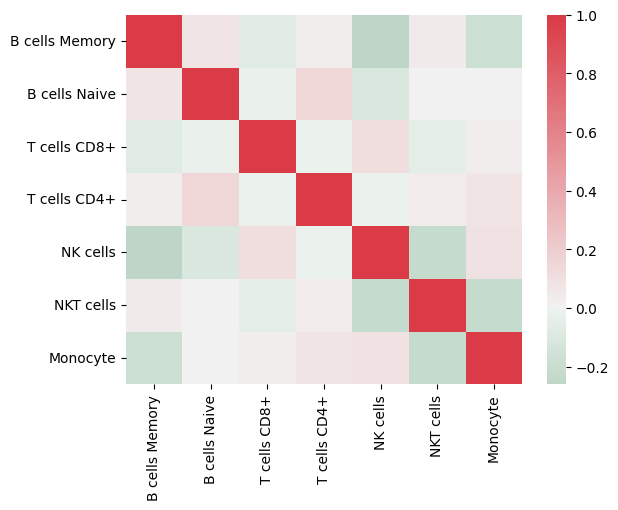

In [8]:
# plot the heatmap
# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if you want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)


sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
           cmap= cmap,
           center=0)
# #save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

In [9]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state=42)

In [10]:

# Create an XGBoost regressor
model = XGBRegressor(objective='reg:squarederror')

# Perform cross-validation on the training data
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

# Print the mean squared error for each fold
print("Cross-validation scores:\n", scores)


Cross-validation scores:
 [0.65640141 0.63515417 0.70419807 0.66327054 0.57122769]


In [11]:

# Train the XGBoost regressor on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the mean squared error on the test data
r2 = r2_score(y_test, y_pred)
print("R2 test data:", r2)

R2 test data: 0.6472198863314771


In [12]:
# Extract variable importance
var_importance = model.get_booster().get_score(importance_type='weight')

# Extract feature weights
weights = model.get_booster().get_score(importance_type='total_gain')
total_gain = sum(weights.values())
weights = {k:v/total_gain for k,v in weights.items()}

# Extract list of columns
columns = model.get_booster().feature_names

# Print the results
print("Variable importance:\n", var_importance)
print("Feature weights:\n", weights)
print("List of columns:\n", columns)


Variable importance:
 {'B cells Memory': 869.0, 'B cells Naive': 68.0, 'T cells CD8+': 37.0, 'T cells CD4+': 21.0, 'NK cells': 638.0, 'NKT cells': 880.0, 'Monocyte': 685.0}
Feature weights:
 {'B cells Memory': 0.0630980042661303, 'B cells Naive': 0.006093377828000967, 'T cells CD8+': 0.006877750815326864, 'T cells CD4+': 0.0020138481342993663, 'NK cells': 0.13613274184876634, 'NKT cells': 0.18505231061494834, 'Monocyte': 0.6007319664925278}
List of columns:
 ['B cells Memory', 'B cells Naive', 'T cells CD8+', 'T cells CD4+', 'NK cells', 'NKT cells', 'Monocyte']


In [13]:
model.get_booster().get_score(importance_type='total_gain')

{'B cells Memory': 68826816.0,
 'B cells Naive': 6646609.5,
 'T cells CD8+': 7502197.5,
 'T cells CD4+': 2196690.0,
 'NK cells': 148492544.0,
 'NKT cells': 201853632.0,
 'Monocyte': 655273792.0}

In [14]:
import statsmodels.api as sm

X_train_2 = sm.add_constant(X_train)  # add intercept
model_lm = sm.OLS(y_train, X_train_2).fit()
print(model_lm.summary())

                            OLS Regression Results                            
Dep. Variable:           Immune_score   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     163.2
Date:                Fri, 21 Apr 2023   Prob (F-statistic):          2.73e-149
Time:                        10:52:44   Log-Likelihood:                -6214.5
No. Observations:                 806   AIC:                         1.244e+04
Df Residuals:                     798   BIC:                         1.248e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2226.7689    102.587     21.

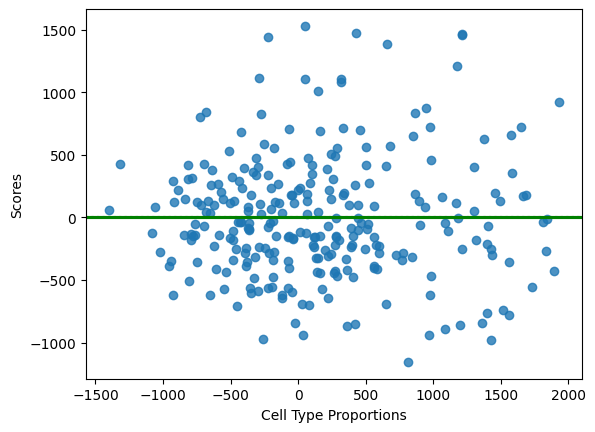

In [21]:
# Plot the residuals
import matplotlib.pyplot as plt
residuals = y_test - y_pred
sns.residplot(x=model.predict(X_test), y=residuals, lowess=True, line_kws=dict(color="g"), order=2)
plt.xlabel("Cell Type Proportions")
plt.ylabel("Scores")
plt.show()


In [16]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=2)

In [17]:
def regression_model(model, X, y):
    # Obtain scores of cross-validation using 10 splits and mean squared error
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kfold)

    # Take square root of the scores
    rmse = (-scores)**0.5

    # Return mean score
    return rmse.mean()


In [18]:
regression_model(XGBRegressor(booster='gblinear', objective='reg:squarederror'),
                X_train, y_train)

550.6593707229521

In [19]:
from sklearn.linear_model import Lasso, Ridge

In [20]:
regression_model(Lasso(),
                  X_train, y_train)

544.3660936361875

In [21]:
regression_model(Ridge(),
                  X_train, y_train)

544.3757491750058

In [22]:
regression_model(XGBRegressor(booster='gbtree', objective='reg:squarederror'),
                X_train, y_train)

489.65181904052713

In [23]:
regression_model(XGBRegressor(booster='dart', objective='reg:squarederror'),
                X_train, y_train)

489.6518191761687

In [24]:
from sklearn.model_selection import GridSearchCV

def grid_search(params, X, y,
                reg=XGBRegressor(booster='gbtree', objective='reg:squarederror')):

    # Instantiate GridSearchCV as grid_reg
    grid_reg = GridSearchCV(reg, params, scoring='neg_mean_squared_error', cv=kfold)
    
    # Fit grid_reg on X_train and y_train
    grid_reg.fit(X, y)

    # Extract best params
    best_params = grid_reg.best_params_

    # Print best params
    print("Best params:", best_params)
    
    # Compute best score
    best_score = np.sqrt(-grid_reg.best_score_)

    # Print best score
    print("Best score:", best_score)


In [25]:
grid_search({'reg_alpha':[0.001, 0.01, 0.1, 0.5, 1, 5]}, X_train, y_train)

Best params: {'reg_alpha': 0.01}
Best score: 494.3826519228838


In [26]:
grid_search({'reg_lambda':[0.001, 0.01, 0.1, 0.5, 1, 5]}, X_train, y_train)

Best params: {'reg_lambda': 1}
Best score: 494.4885283422524


In [27]:
reg = XGBRegressor(booster='gblinear', objective='reg:squarederror')
grid_search({'feature_selector':['greedy', 'thrifty'], 'updater':['coord_descent'], 'top_k':[3, 5, 7, 9]},
           X_train, y_train, reg)

Best params: {'feature_selector': 'greedy', 'top_k': 7, 'updater': 'coord_descent'}
Best score: 554.6429237015808


In [28]:
reg = XGBRegressor(booster='gblinear', objective='reg:squarederror')
grid_search({'feature_selector':['random', 'greedy', 'thrifty'], 'updater':['coord_descent'] },
           X_train, y_train, reg)

Best params: {'feature_selector': 'greedy', 'updater': 'coord_descent'}
Best score: 554.6429237015808


In [51]:
model=XGBRegressor(booster='gbtree', 
                   objective='reg:squarederror', 
                   reg_alpha=0.01,
                   reg_lambda=1,
                  )

# Train the XGBoost regressor on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the mean squared error and r2 on the test data
mse = mean_squared_error(y_test, y_pred)
print("MSE test data:", mse**0.5)

r2 = r2_score(y_test, y_pred)
print("R2 test data:", r2)


MSE test data: 494.5889897127165
R2 test data: 0.6464851584733675


In [48]:
model.feature_importances_

array([0.04092379, 0.05060414, 0.11096349, 0.05415586, 0.11941845,
       0.11999715, 0.5039371 ], dtype=float32)

Text(0.5, 0, 'Xgboost Feature Importance')

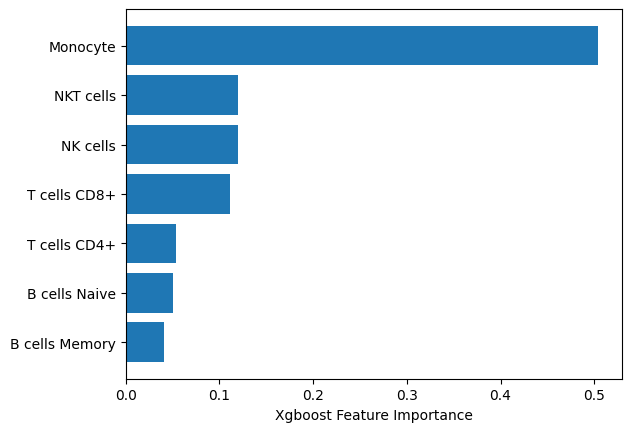

In [47]:
sorted_idx = model.feature_importances_.argsort()
plt.barh(data.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

In [31]:
# Extract variable importance
var_importance = model.get_booster().get_score(importance_type='weight')

# Extract feature weights
weights = model.get_booster().get_score(importance_type='total_gain')
mean_weights = np.mean (np.array(list(weights.values())))
print(mean_weights)
std_weights = np.std(np.array(list(weights.values())))
print(std_weights)

sc_weights = {k:np.abs((v-mean_weights)/std_weights) for k,v in weights.items()}

# Extract list of columns
columns = model.get_booster().feature_names

from sklearn.preprocessing import StandardScaler
    
# Print the results
print("Variable importance:\n", var_importance)
print("Weights:\n", weights)
print("Feature weights:\n", sc_weights)
print("List of columns:\n", columns)


155835641.64285713
216074774.31681123
Variable importance:
 {'B cells Memory': 873.0, 'B cells Naive': 68.0, 'T cells CD8+': 35.0, 'T cells CD4+': 21.0, 'NK cells': 644.0, 'NKT cells': 871.0, 'Monocyte': 673.0}
Weights:
 {'B cells Memory': 69006504.0, 'B cells Naive': 6646529.5, 'T cells CD8+': 7501500.5, 'T cells CD4+': 2196669.5, 'NK cells': 148544736.0, 'NKT cells': 201878032.0, 'Monocyte': 655075520.0}
Feature weights:
 {'B cells Memory': 0.40184763777907406, 'B cells Naive': 0.69045131535861, 'T cells CD8+': 0.6864944860493895, 'T cells CD4+': 0.7110453898592992, 'NK cells': 0.03374251189621574, 'NKT cells': 0.21308544925116987, 'Monocyte': 2.310495891691419}
List of columns:
 ['B cells Memory', 'B cells Naive', 'T cells CD8+', 'T cells CD4+', 'NK cells', 'NKT cells', 'Monocyte']


Text(0.5, 0, 'Permutation Importance')

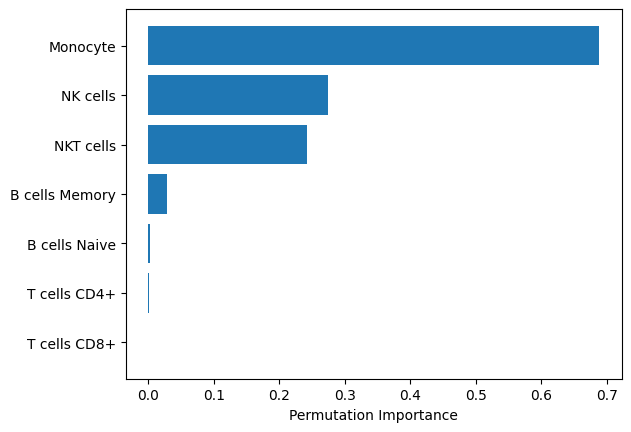

In [32]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(model, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(data.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [35]:
from shap import TreeExplainer, summary_plot
explainer = TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


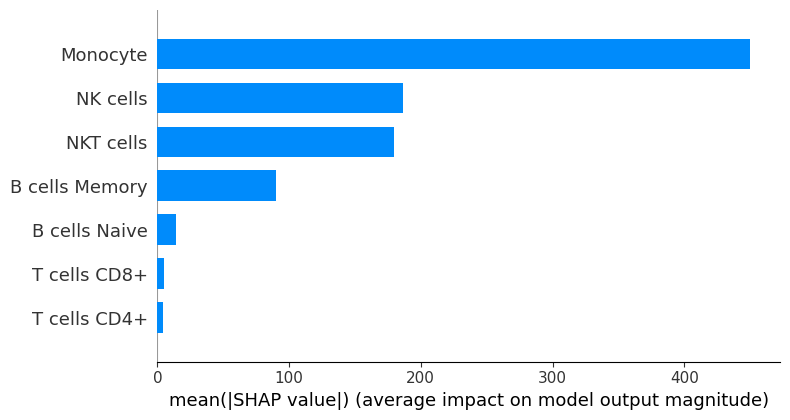

In [36]:
summary_plot(shap_values, X_test, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


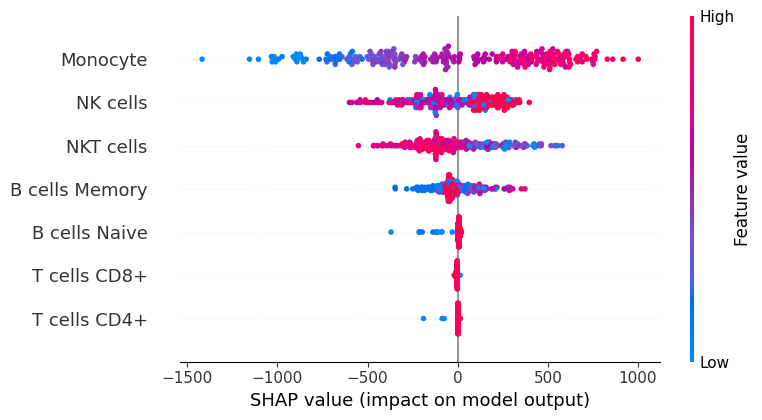

In [37]:
summary_plot(shap_values, X_test)

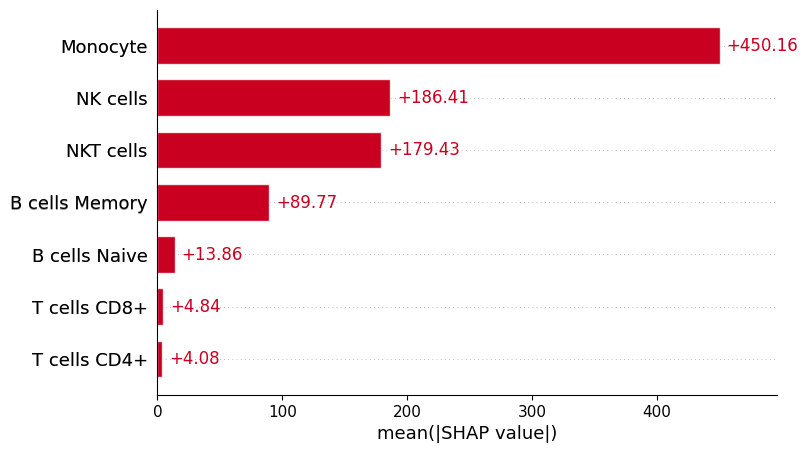

In [55]:
# Plot bar plot
import shap
import matplotlib
# Default SHAP colors
default_pos_color = "#ff0051"
default_neg_color = "#008bfb"
# Custom colors
positive_color = "#ca0020"
negative_color = "#92c5de"

fig = shap.plots.bar(explainer(X_test), show = False)
# Change the colormap of the artists
for fc in plt.gcf().get_children():
    # Ignore last Rectangle
    for fcc in fc.get_children()[:-1]:
        if (isinstance(fcc, matplotlib.patches.Rectangle)):
            if (matplotlib.colors.to_hex(fcc.get_facecolor()) == default_pos_color):
                fcc.set_facecolor(positive_color)
            elif (matplotlib.colors.to_hex(fcc.get_facecolor()) == default_neg_color):
                fcc.set_color(negative_color)
        elif (isinstance(fcc, plt.Text)):
            if (matplotlib.colors.to_hex(fcc.get_color()) == default_pos_color):
                fcc.set_color(positive_color)
            elif (matplotlib.colors.to_hex(fcc.get_color()) == default_neg_color):
                fcc.set_color(negative_color)
path = "../data/brca/tcga/processed/tumor_shap.png"
plt.savefig(path)                
plt.show()
plt.close()

In [38]:
import statsmodels.api as sm

y_test_2 = sm.add_constant(y_test)  # add intercept
residuals = y_test - y_pred
model_lm = sm.OLS(residuals, y_test_2).fit()
print(model_lm.summary())

                            OLS Regression Results                            
Dep. Variable:           Immune_score   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     102.7
Date:                Fri, 21 Apr 2023   Prob (F-statistic):           1.25e-20
Time:                        10:49:03   Log-Likelihood:                -2003.1
No. Observations:                 269   AIC:                             4010.
Df Residuals:                     267   BIC:                             4017.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            7.5805     26.311      0.288   